In [2]:
import os

import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as pl
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# Load dataset
data = pd.read_csv("C:\\Users\\Hasan\\Desktop\\data science folder\\raw_analyst_ratings.csv")
print(data.head())

   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None


In [5]:
# Check for missing values
print(data.isnull().sum())

# Check unique values in each column
print(data.nunique())

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64
Unnamed: 0    1407328
headline       845770
url            883429
publisher        1034
date            39957
stock            6204
dtype: int64


2009-02-14 00:00:00-04:00 2020-06-11 17:12:35-04:00


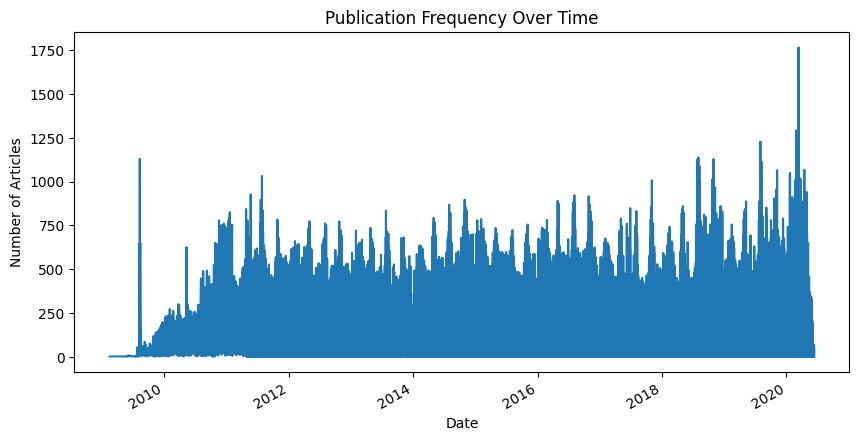

In [6]:
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='ISO8601', errors='coerce')

# Check the range of dates
print(data['date'].min(), data['date'].max())

# Group by date to see publication frequency
date_counts = data['date'].value_counts().sort_index()
# Plot the distribution
plt.figure(figsize=(10, 5))
date_counts.plot(kind='line')
plt.title("Publication Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


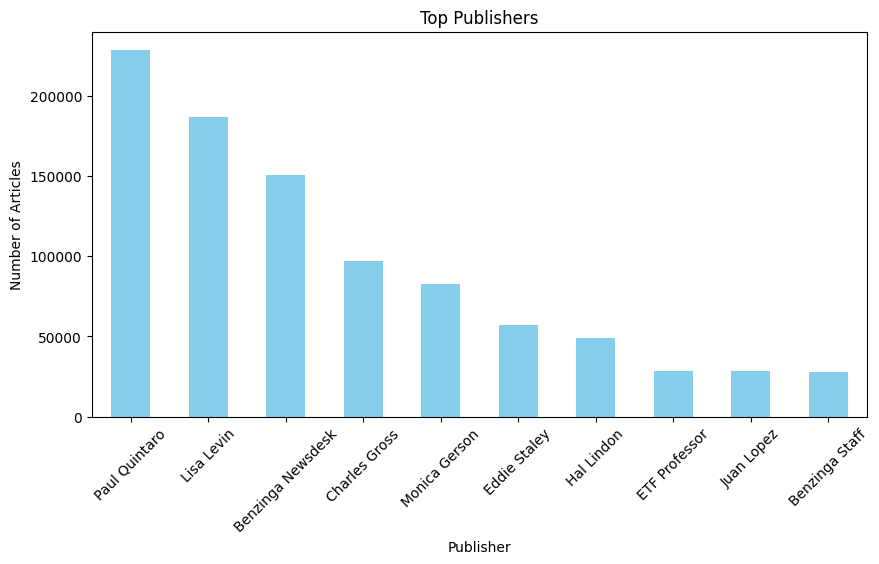

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


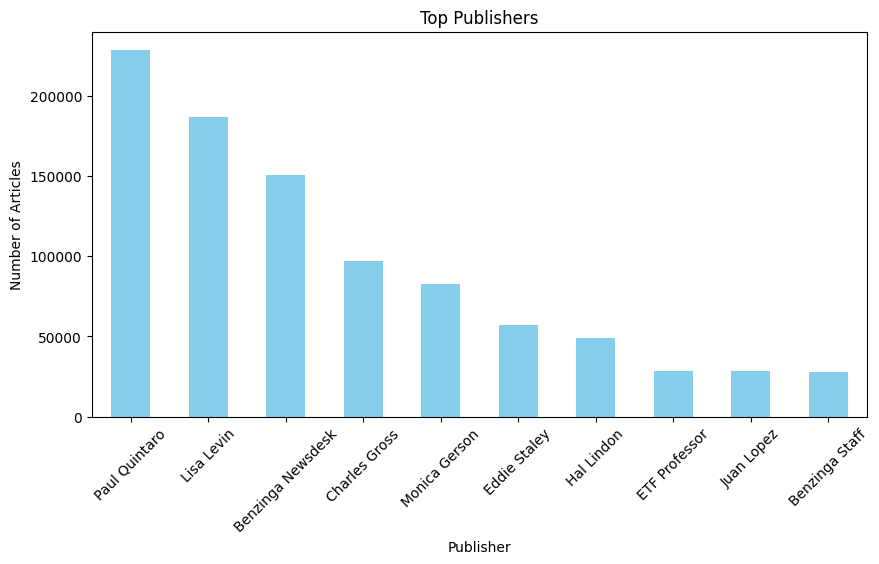

In [7]:
# Top publishers by count
top_publishers = data['publisher'].value_counts().head(10)
print(top_publishers)

# Plot top publishers
top_publishers.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title("Top Publishers")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()
# Top publishers by count
top_publishers = data['publisher'].value_counts().head(10)
print(top_publishers)

# Plot top publishers
top_publishers.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title("Top Publishers")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()

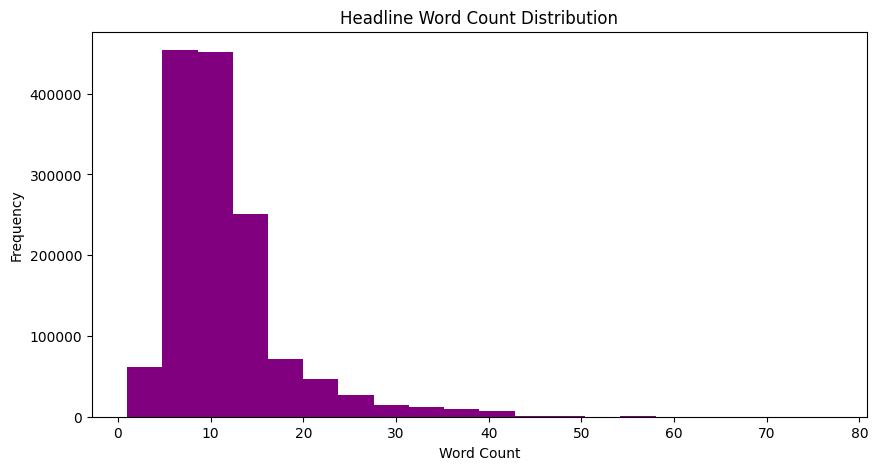

In [8]:
data['headline_word_count'] = data['headline'].apply(lambda x: len(str(x).split()))

# Plot word count distribution
data['headline_word_count'].plot(kind='hist', bins=20, figsize=(10, 5), color='purple')
plt.title("Headline Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

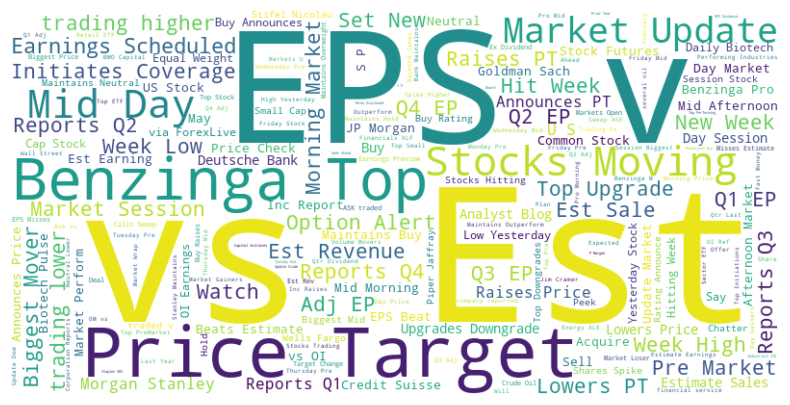

In [9]:
# Join all headlines
all_headlines = " ".join(data['headline'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_headlines)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
        ... 
DWM        1
DWAT       1
DVP        1
DXJS       1
DXJR       1
Name: count, Length: 6204, dtype: int64


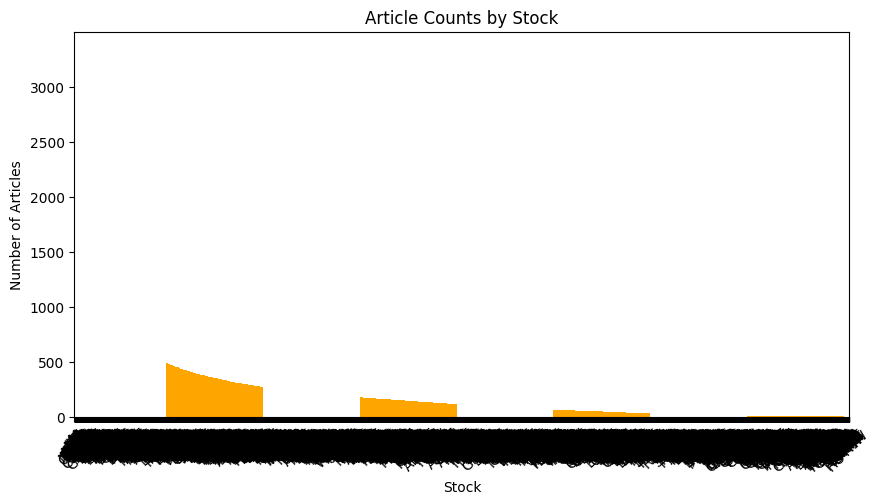

In [10]:
# Check stock distribution
print(data['stock'].value_counts())

# Plot stock distribution
data['stock'].value_counts().plot(kind='bar', figsize=(10, 5), color='orange')
plt.title("Article Counts by Stock")
plt.xlabel("Stock")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()

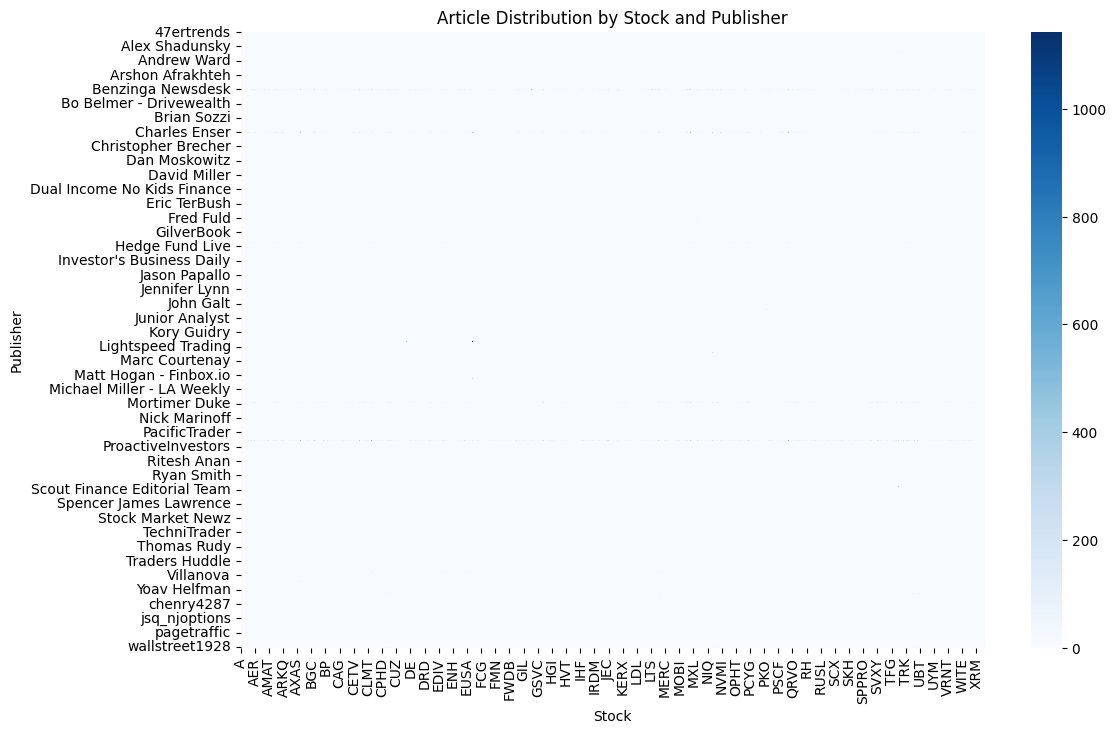

In [11]:
# Group by stock and publisher
stock_publisher = data.groupby(['publisher', 'stock']).size().unstack(fill_value=0)

# Display heatmap
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(stock_publisher, cmap="Blues", annot=False)
plt.title("Article Distribution by Stock and Publisher")
plt.ylabel("Publisher")
plt.xlabel("Stock")
plt.show()

C:\Users\Hasan\AppData\Local\Temp\ipykernel_15628\2261947954.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['week'] = filtered_data['date'].dt.to_period('W')
C:\Users\Hasan\AppData\Local\Temp\ipykernel_15628\2261947954.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['week'] = filtered_data['date'].dt.to_period('W')
C:\Users\Hasan\AppData\Local\Temp\ipykernel_15628\2261947954.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stock_date = filtered_data.groupby(['week', 's

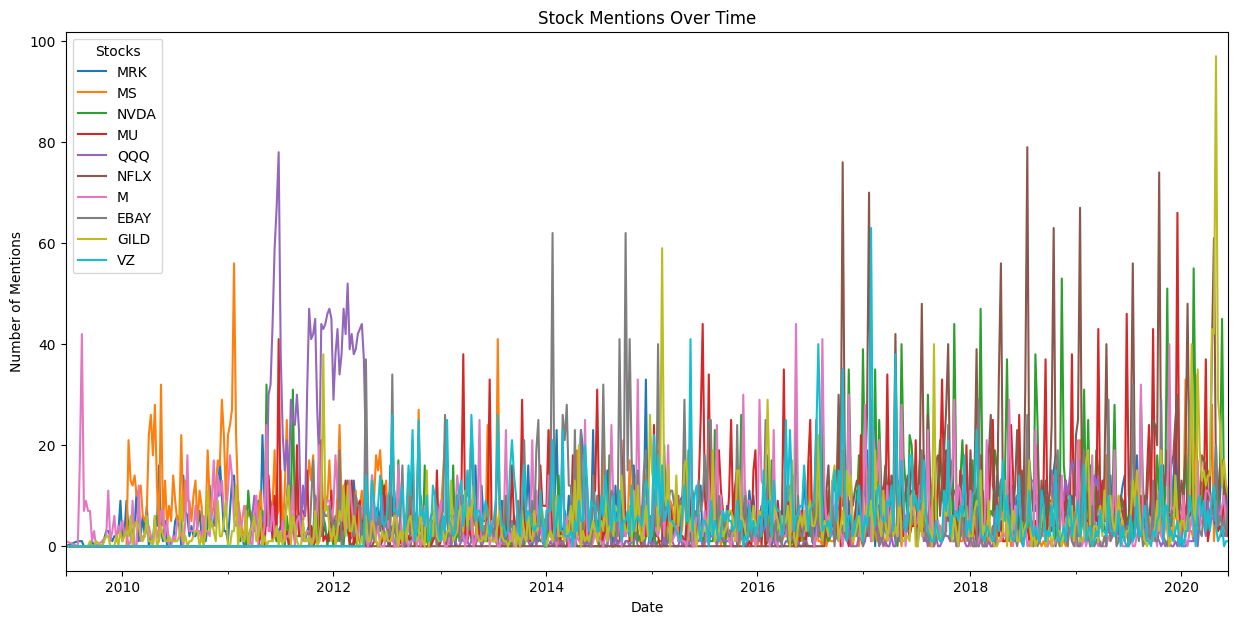

In [12]:
# Convert date to datetime and stock to category
data['date'] = pd.to_datetime(data['date'])
data['stock'] = data['stock'].astype('category')

# Get top 10 most mentioned stocks
top_stocks = data['stock'].value_counts().nlargest(10).index

# Filter data for top stocks
filtered_data = data[data['stock'].isin(top_stocks)]

# Add a 'week' column for weekly aggregation
filtered_data['week'] = filtered_data['date'].dt.to_period('W')

# Group by week and stock
stock_date = filtered_data.groupby(['week', 'stock']).size().unstack(fill_value=0)

# Plot time series for top stocks
stock_date[top_stocks].plot(figsize=(15, 7))
plt.title("Stock Mentions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.legend(title="Stocks", loc='upper left')
plt.show()

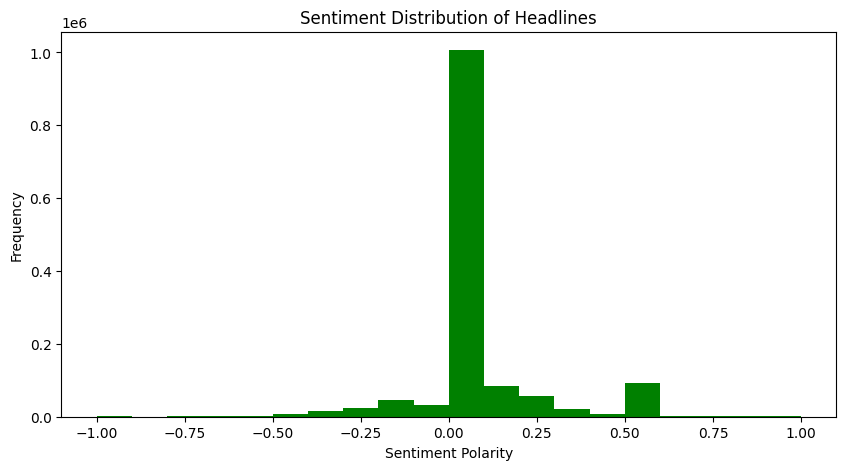

In [13]:
# Add sentiment scores
data['sentiment'] = data['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Check sentiment distribution
data['sentiment'].plot(kind='hist', bins=20, figsize=(10, 5), color='green')
plt.title("Sentiment Distribution of Headlines")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#op Modelling
# Convert headlines to a document-term matrix
vectorizer = CountVectorizer(stop_words='english')
headline_matrix = vectorizer.fit_transform(data['headline'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(headline_matrix)

# Display topics
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([words[i] for i in topic.argsort()[-10:]])

In [ ]:
#Export Result
# Save dataset with new features
data.to_csv("raw_analyst_ratings", index=False)